# Training XGBoost Model - Dynamic Configuration

## Mục tiêu
Notebook training XGBoost động có thể chạy cho bất kỳ configuration nào trong EXPERIMENTS.
Chỉ cần thay đổi CONFIG_NAME ở cell đầu tiên để train configuration khác.

## Cách sử dụng
1. Chọn CONFIG_NAME từ danh sách: '7n_1n', '30n_1n', '30n_7n', '30n_30n', '90n_7n', '90n_30n'
2. Run all cells
3. Kết quả sẽ được lưu tự động theo configuration

## Troubleshooting
- **Memory issues**: Giảm CV folds hoặc simplify parameter grid
- **Slow training**: Giảm số parameter combinations

In [1]:
# ===============================================
# CONFIGURATION - THAY ĐỔI TẠI ĐÂY
# ===============================================
CONFIG_NAME = '90n_30n'  # Thay đổi theo experiment muốn chạy

# Available configurations:
# '7n_1n'    : 7 days → 1 day
# '30n_1n'   : 30 days → 1 day  
# '30n_7n'   : 30 days → 7 days
# '30n_30n'  : 30 days → 30 days
# '90n_7n'   : 90 days → 7 days
# '90n_30n'  : 90 days → 30 days

In [2]:
import sys
sys.path.append('../src')
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost_trainer import train_xgboost_model
from config import EXPERIMENTS, XGBOOST_PARAMS, RANDOM_SEED
import warnings
import json
import os
import time
from datetime import datetime

warnings.filterwarnings('ignore')
np.random.seed(RANDOM_SEED)

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

# Validate configuration
if CONFIG_NAME not in EXPERIMENTS:
    raise ValueError(f"Invalid CONFIG_NAME: {CONFIG_NAME}. Available: {list(EXPERIMENTS.keys())}")

# Get experiment configuration
experiment_config = EXPERIMENTS[CONFIG_NAME]
N_DAYS = experiment_config['N']
M_DAYS = experiment_config['M']
DESCRIPTION = experiment_config['description']

print(f"✅ Configuration loaded: {CONFIG_NAME}")
print(f"📊 Experiment: {DESCRIPTION}")
print(f"📥 Input: {N_DAYS} days")
print(f"📤 Output: {M_DAYS} days")
print(f"🎲 Random seed: {RANDOM_SEED}")
print(f"⏰ Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Configuration loaded: 90n_30n
📊 Experiment: 90 days input to predict 30 days
📥 Input: 90 days
📤 Output: 30 days
🎲 Random seed: 28112001
⏰ Start time: 2025-07-31 13:46:13


## Configuration-Specific Information

In [3]:
MODEL_TYPE = 'XGBoost'

print(f"=== TRAINING {MODEL_TYPE} MODEL: {CONFIG_NAME} ===")
print(f"Cấu hình: {N_DAYS} ngày đầu vào → {M_DAYS} ngày dự đoán")
print(f"Mô tả: {DESCRIPTION}")
print(f"Target: Mực nước Cần Thơ")
print(f"Model: {MODEL_TYPE} với tabular lag features")

# Expected data characteristics
# intervals_per_day = 96  # 24 hours * 4 (15-minute intervals)
features_per_interval = 6  # 3 stations * 2 parameters
total_lag_features = N_DAYS* features_per_interval # * intervals_per_day 

print(f"\nExpected data characteristics:")
print(f"  Input timesteps: {N_DAYS} (15-min intervals)")
print(f"  Features per timestep: {features_per_interval}")
print(f"  Total lag features: {total_lag_features:,}")
print(f"  Output type: {'Single value' if M_DAYS == 1 else f'Aggregated over {M_DAYS} days'}")

print(f"\nGrid search parameters:")
for param, values in XGBOOST_PARAMS.items():
    print(f"  {param}: {values}")
    
total_combinations = np.prod([len(v) for v in XGBOOST_PARAMS.values()])
print(f"\nTotal hyperparameter combinations: {total_combinations}")

=== TRAINING XGBoost MODEL: 90n_30n ===
Cấu hình: 90 ngày đầu vào → 30 ngày dự đoán
Mô tả: 90 days input to predict 30 days
Target: Mực nước Cần Thơ
Model: XGBoost với tabular lag features

Expected data characteristics:
  Input timesteps: 90 (15-min intervals)
  Features per timestep: 6
  Total lag features: 540
  Output type: Aggregated over 30 days

Grid search parameters:
  n_estimators: [100, 300, 500]
  max_depth: [3, 5, 7]
  learning_rate: [0.01, 0.1, 0.3]
  subsample: [0.5, 0.8, 1.0]

Total hyperparameter combinations: 81


## Kiểm tra dữ liệu

In [4]:
# Kiểm tra dữ liệu có sẵn - Enhanced validation from notebook 05
data_folder = '../data'
config_folder = f"{data_folder}/{CONFIG_NAME}_xgb"

print(f"🔍 Checking data availability for {CONFIG_NAME}...")

def validate_data_for_config():
    """Validate data availability for the selected configuration"""
    if not os.path.exists(config_folder):
        return False, f"Data folder does not exist: {config_folder}"
    
    # Check required files
    required_files = ['X_train.csv', 'X_test.csv', 'y_train.csv', 'y_test.csv', 'metadata.json']
    missing_files = []
    
    for file in required_files:
        file_path = f"{config_folder}/{file}"
        if not os.path.exists(file_path):
            missing_files.append(file)
    
    if missing_files:
        return False, f"Missing files: {missing_files}"
    
    return True, "All data files available"

# Validate data
data_ready, message = validate_data_for_config()

if data_ready:
    print(f"✅ {message}")
    
    # Load metadata
    metadata_file = f"{config_folder}/metadata.json"
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
    
    print(f"\n📊 Data Information:")
    print(f"  X_train shape: {metadata['X_train_shape']}")
    print(f"  X_test shape: {metadata['X_test_shape']}")
    print(f"  y_train shape: {metadata['y_train_shape']}")
    print(f"  y_test shape: {metadata['y_test_shape']}")
    print(f"  Target: {metadata['target_col']}")
    print(f"  Created: {metadata.get('created_at', 'Unknown')}")
    
    # Validate expected vs actual features
    actual_features = metadata['X_train_shape'][1]
    if actual_features == total_lag_features:
        print(f"  ✅ Feature count matches expectation: {actual_features:,}")
    else:
        print(f"  ⚠️  Feature count mismatch: expected {total_lag_features:,}, got {actual_features:,}")
else:
    print(f"❌ {message}")
    print(f"💡 Please run notebook 02_feature_engineering.ipynb first")
    raise RuntimeError(f"Data not ready for {CONFIG_NAME}")

# Check if model already exists
model_folder = f"../models/{CONFIG_NAME}_xgb"
model_file = f"{model_folder}/best_model.pkl"

if os.path.exists(model_file):
    print(f"\n⚠️  Model already exists: {model_file}")
    print(f"🔄 Training will overwrite existing model.")
else:
    print(f"\n🆕 Training new model for {CONFIG_NAME}")

print(f"\n🎯 Ready to start training!")

🔍 Checking data availability for 90n_30n...
✅ All data files available

📊 Data Information:
  X_train shape: [7328, 540]
  X_test shape: [1743, 540]
  y_train shape: [7328]
  y_test shape: [1743]
  Target: Can Tho_Water Level
  Created: 2025-07-31T13:36:03.376809
  ✅ Feature count matches expectation: 540

⚠️  Model already exists: ../models/90n_30n_xgb/best_model.pkl
🔄 Training will overwrite existing model.

🎯 Ready to start training!


## Training với Grid Search

In [5]:
# Enhanced training with progress tracking from notebook 05
print(f"\n🚀 Starting XGBoost training for {CONFIG_NAME}...")
print(f"📊 Experiment: {DESCRIPTION}")
print(f"🔢 Total combinations: {total_combinations}")
print(f"⏰ Estimated time: {total_combinations * 1.5:.0f}-{total_combinations * 3:.0f} minutes")
print(f"🎯 Parameters: {XGBOOST_PARAMS}")

start_time = time.time()

try:
    print(f"\n📈 Starting grid search with 3-fold CV...")
    
    trainer = train_xgboost_model(
        config_name=CONFIG_NAME,
        param_grid=XGBOOST_PARAMS,
        data_folder='../data',
        models_folder='../models',
        cv_folds=3  # 3-fold time series CV
    )
    
    training_time = time.time() - start_time
    print(f"\n✅ Training completed successfully!")
    print(f"⏱️  Total time: {training_time/60:.1f} minutes")
    print(f"💾 Model saved to: ../models/{CONFIG_NAME}_xgb/")
    
except Exception as e:
    training_time = time.time() - start_time
    print(f"\n❌ Training failed after {training_time/60:.1f} minutes")
    print(f"💥 Error: {str(e)}")
    import traceback
    traceback.print_exc()
    raise
    print(f"Error: {e}")
    raise e


🚀 Starting XGBoost training for 90n_30n...
📊 Experiment: 90 days input to predict 30 days
🔢 Total combinations: 81
⏰ Estimated time: 122-243 minutes
🎯 Parameters: {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.3], 'subsample': [0.5, 0.8, 1.0]}

📈 Starting grid search with 3-fold CV...
Loaded data for 90n_30n:
  X_train: (7328, 540)
  X_test: (1743, 540)
  y_train: (7328,)
  y_test: (1743,)
\nStarting grid search for 90n_30n...
Parameter grid: {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.3], 'subsample': [0.5, 0.8, 1.0]}
CV folds: 3
Fitting 3 folds for each of 81 candidates, totalling 243 fits
\nBest parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
Best CV score: -0.074348
\nTraining final model with best parameters...
Model trained successfully!
Top 10 most important features:
                          feature  importance
43     lag_8d_Can Tho_Water Level    

## Phân tích kết quả theo Configuration

In [6]:
# Load và hiển thị kết quả chi tiết
results_folder = f"../models/{CONFIG_NAME}_xgb"

# Load results
with open(f"{results_folder}/results.json", 'r') as f:
    results = json.load(f)

print(f"=== KẾT QUẢ TRAINING {CONFIG_NAME} ===")
print(f"Configuration: {DESCRIPTION}")
print(f"Model type: {results['model_type']}")
print(f"Training time: {training_time/60:.1f} minutes")

print(f"\nBest parameters:")
for param, value in results['best_params'].items():
    print(f"  {param}: {value}")

print(f"\nBest CV score: {results['best_cv_score']:.6f}")

print(f"\nTraining metrics:")
for metric, value in results['train_metrics'].items():
    print(f"  {metric}: {value:.6f}")

print(f"\nTest metrics:")
for metric, value in results['test_metrics'].items():
    print(f"  {metric}: {value:.6f}")

print(f"\nModel complexity:")
print(f"  Features: {results['feature_count']:,}")
print(f"  Data shapes: {results['data_shapes']}")
print(f"  Training samples: {results['data_shapes']['X_train'][0]:,}")
print(f"  Test samples: {results['data_shapes']['X_test'][0]:,}")

# Performance interpretation based on configuration
rmse = results['test_metrics']['RMSE']
r2 = results['test_metrics']['R2']

print(f"\n📊 Performance Assessment cho {CONFIG_NAME}:")
if r2 > 0.95:
    performance = "Excellent (R² > 0.95)"
elif r2 > 0.90:
    performance = "Very Good (R² > 0.90)"
elif r2 > 0.80:
    performance = "Good (R² > 0.80)"
elif r2 > 0.70:
    performance = "Fair (R² > 0.70)"
else:
    performance = "Needs Improvement (R² ≤ 0.70)"

print(f"  Overall: {performance}")
print(f"  RMSE: {rmse:.4f} m (±{rmse*100:.1f} cm average error)")
print(f"  R²: {r2:.4f} ({r2*100:.1f}% variance explained)")

# Configuration-specific insights
if M_DAYS == 1:
    print(f"  Short-term prediction (1 day): {'Good accuracy expected' if r2 > 0.85 else 'May need improvement'}")
elif M_DAYS <= 7:
    print(f"  Medium-term prediction ({M_DAYS} days): {'Reasonable accuracy' if r2 > 0.75 else 'Challenging prediction horizon'}")
else:
    print(f"  Long-term prediction ({M_DAYS} days): {'Impressive accuracy' if r2 > 0.65 else 'Expected lower accuracy for long-term'}")

if N_DAYS >= 365:
    print(f"  Long input history ({N_DAYS} days): {'Captures seasonal patterns well' if r2 > 0.8 else 'May have overfitting issues'}")
elif N_DAYS >= 30:
    print(f"  Medium input history ({N_DAYS} days): {'Good balance of history and efficiency' if r2 > 0.8 else 'Consider longer history'}")
else:
    print(f"  Short input history ({N_DAYS} days): {'Efficient for short-term patterns' if r2 > 0.85 else 'May need longer history'}")

=== KẾT QUẢ TRAINING 90n_30n ===
Configuration: 90 days input to predict 30 days
Model type: XGBoost
Training time: 15.9 minutes

Best parameters:
  learning_rate: 0.01
  max_depth: 5
  n_estimators: 500
  subsample: 0.8

Best CV score: -0.074348

Training metrics:
  MAE: 0.126090
  MSE: 0.028056
  RMSE: 0.167500
  R2: 0.919289

Test metrics:
  MAE: 0.233413
  MSE: 0.094457
  RMSE: 0.307339
  R2: 0.710566

Model complexity:
  Features: 540
  Data shapes: {'X_train': [7328, 540], 'X_test': [1743, 540], 'y_train': [7328], 'y_test': [1743]}
  Training samples: 7,328
  Test samples: 1,743

📊 Performance Assessment cho 90n_30n:
  Overall: Fair (R² > 0.70)
  RMSE: 0.3073 m (±30.7 cm average error)
  R²: 0.7106 (71.1% variance explained)
  Long-term prediction (30 days): Impressive accuracy
  Medium input history (90 days): Consider longer history


## Feature Importance Analysis

=== TOP 20 MOST IMPORTANT FEATURES - 90n_30n ===
                     feature  importance
  lag_8d_Can Tho_Water Level    0.171507
lag_16d_Dai Ngai_Water Level    0.024620
lag_34d_Chau Doc_Water Level    0.014485
 lag_8d_Dai Ngai_Water Level    0.014088
lag_21d_Chau Doc_Water Level    0.013012
lag_88d_Chau Doc_Water Level    0.010373
lag_89d_Chau Doc_Water Level    0.009116
     lag_9d_Can Tho_Rainfall    0.008387
 lag_1d_Chau Doc_Water Level    0.008328
 lag_4d_Chau Doc_Water Level    0.007701
   lag_31d_Dai Ngai_Rainfall    0.007544
   lag_25d_Chau Doc_Rainfall    0.007192
lag_26d_Chau Doc_Water Level    0.005619
 lag_87d_Can Tho_Water Level    0.005413
lag_24d_Dai Ngai_Water Level    0.005347
lag_87d_Dai Ngai_Water Level    0.004929
 lag_25d_Can Tho_Water Level    0.004542
 lag_28d_Can Tho_Water Level    0.004441
lag_42d_Chau Doc_Water Level    0.004274
 lag_9d_Chau Doc_Water Level    0.004188


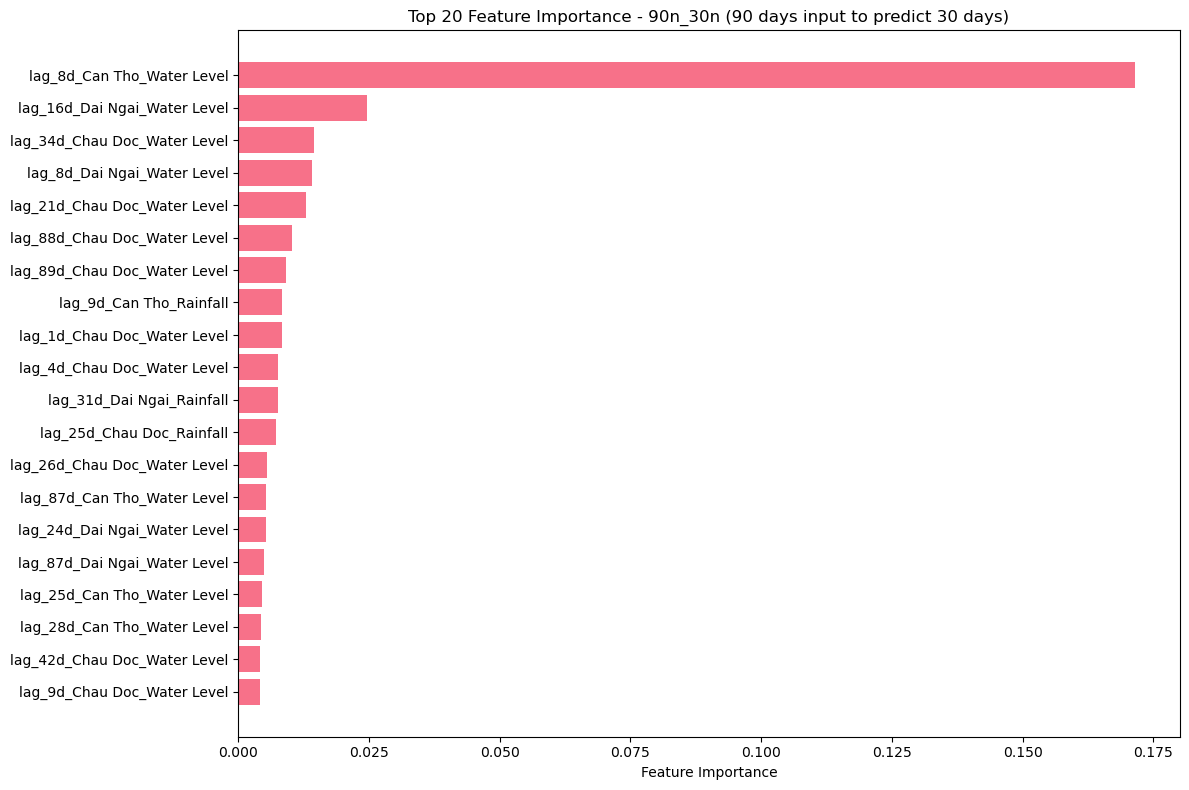


=== FEATURE ANALYSIS BY TIME LAG - 90n_30n ===

Importance by Station:
  Can Tho: 0.416 (41.6%)
  Chau Doc: 0.296 (29.6%)
  Dai Ngai: 0.288 (28.8%)

Importance by Parameter:
  Water Level: 0.750 (75.0%)
  Rainfall: 0.250 (25.0%)

💡 Insights for 90n_30n:
  - Cần Thơ features dominant (local patterns important)
  - Water level history more important than rainfall for 30-day prediction


In [7]:
# Load feature importance
feature_importance = pd.read_csv(f"{results_folder}/feature_importance.csv")

print(f"=== TOP 20 MOST IMPORTANT FEATURES - {CONFIG_NAME} ===")
print(feature_importance.head(20).to_string(index=False))

# Plot top features with configuration-specific title
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title(f'Top 20 Feature Importance - {CONFIG_NAME} ({DESCRIPTION})')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Analyze features by time lag for this configuration
print(f"\n=== FEATURE ANALYSIS BY TIME LAG - {CONFIG_NAME} ===")
feature_importance['station'] = feature_importance['feature'].str.extract(r'(Can Tho|Chau Doc|Dai Ngai)')
feature_importance['parameter'] = feature_importance['feature'].str.extract(r'(Rainfall|Water Level)')
feature_importance['lag_hours'] = feature_importance['feature'].str.extract(r'lag_(\d+\.\d+)h').astype(float)

# Analyze by station
station_importance = feature_importance.groupby('station')['importance'].sum().sort_values(ascending=False)
print("\nImportance by Station:")
for station, importance in station_importance.items():
    print(f"  {station}: {importance:.3f} ({importance/station_importance.sum()*100:.1f}%)")

# Analyze by parameter type
param_importance = feature_importance.groupby('parameter')['importance'].sum().sort_values(ascending=False)
print("\nImportance by Parameter:")
for param, importance in param_importance.items():
    print(f"  {param}: {importance:.3f} ({importance/param_importance.sum()*100:.1f}%)")

# Analyze temporal patterns
if not feature_importance['lag_hours'].isna().all():
    # Group by time periods
    feature_importance['time_period'] = pd.cut(
        feature_importance['lag_hours'], 
        bins=[0, 24, 24*7, 24*30, float('inf')],
        labels=['Recent (0-1d)', 'Short (1-7d)', 'Medium (1-4w)', 'Long (>1m)']
    )
    
    time_importance = feature_importance.groupby('time_period')['importance'].sum().sort_values(ascending=False)
    print(f"\nImportance by Time Period for {CONFIG_NAME}:")
    for period, importance in time_importance.items():
        print(f"  {period}: {importance:.3f} ({importance/time_importance.sum()*100:.1f}%)")

# Configuration-specific insights
print(f"\n💡 Insights for {CONFIG_NAME}:")
if 'Can Tho' in station_importance.index and station_importance['Can Tho'] > 0.4:
    print(f"  - Cần Thơ features dominant (local patterns important)")
if 'Chau Doc' in station_importance.index and station_importance['Chau Doc'] > 0.3:
    print(f"  - Châu Đốc (upstream) significantly influences prediction")
if 'Water Level' in param_importance.index and param_importance['Water Level'] > param_importance.get('Rainfall', 0):
    print(f"  - Water level history more important than rainfall for {M_DAYS}-day prediction")
else:
    print(f"  - Rainfall patterns significant for {M_DAYS}-day prediction")

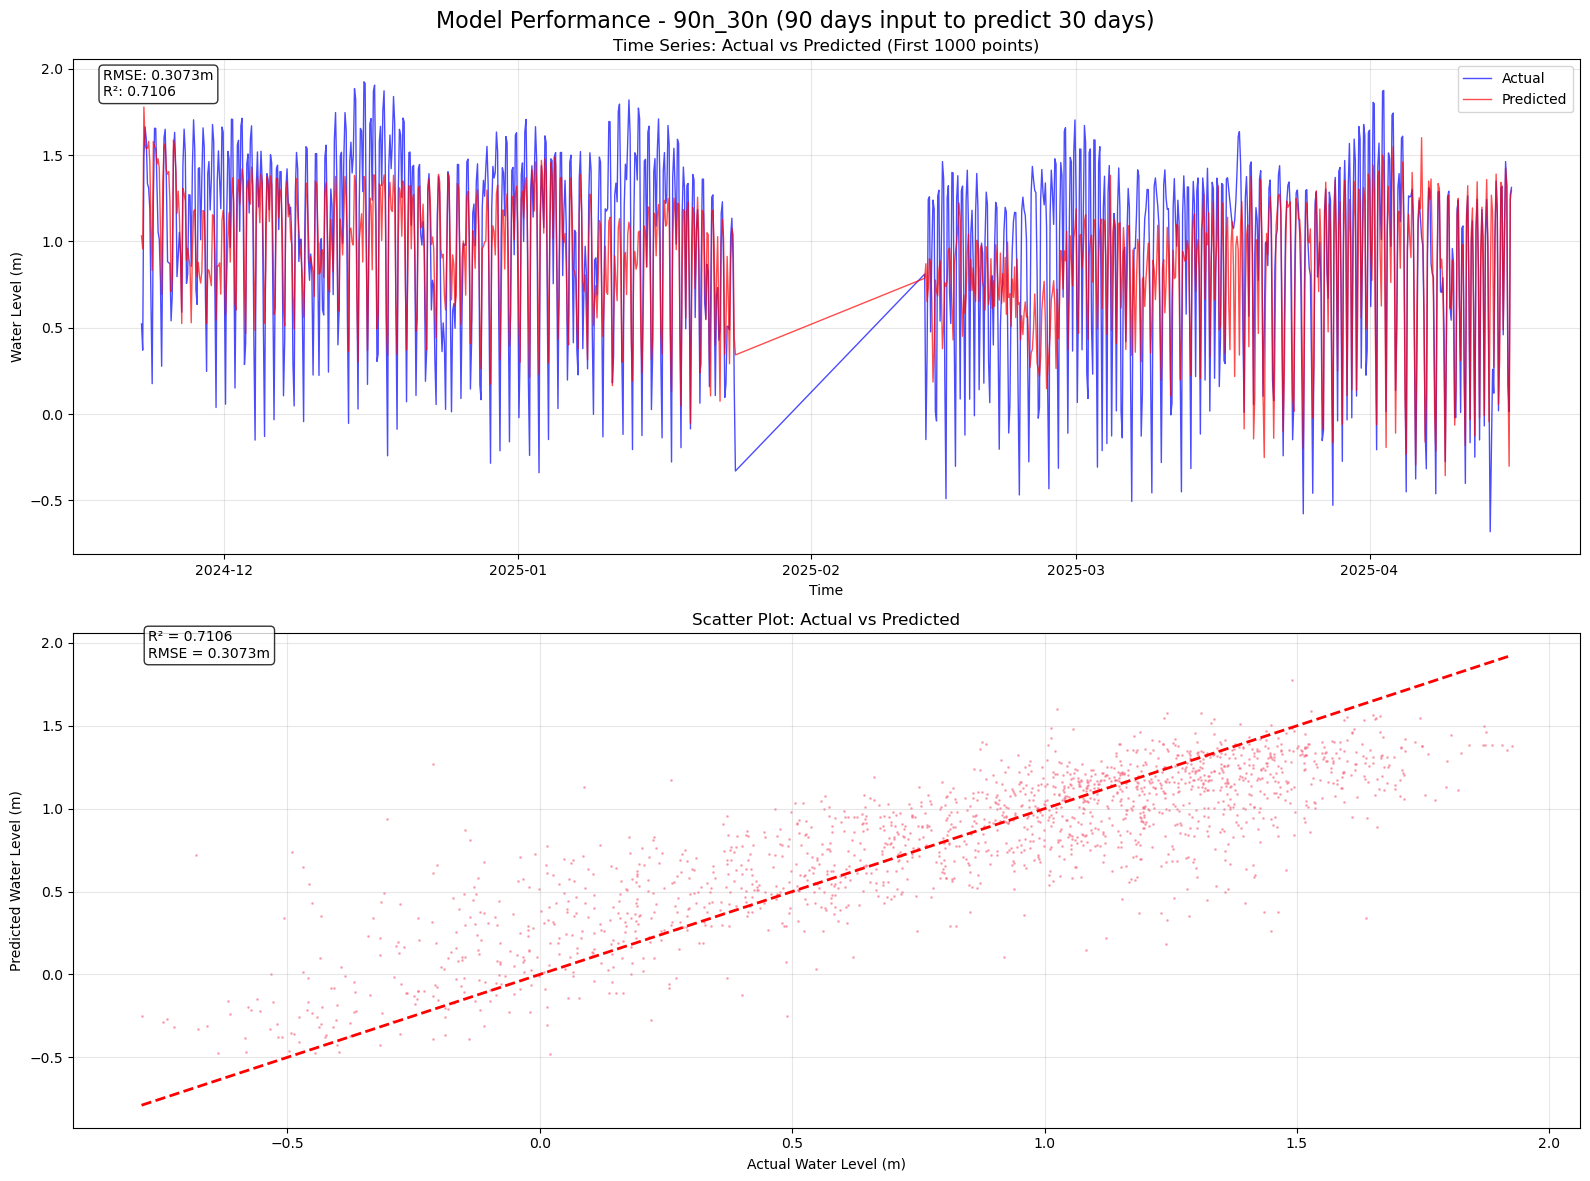

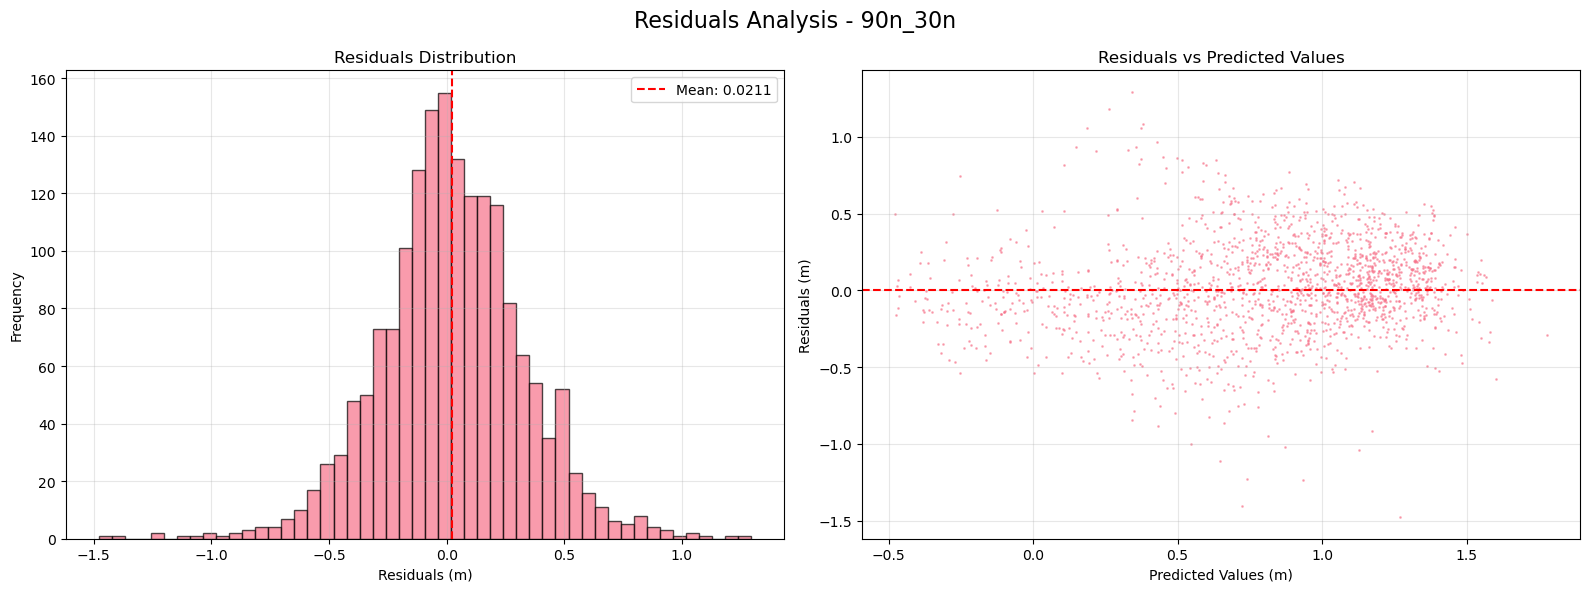


=== RESIDUALS ANALYSIS - 90n_30n ===
Configuration: 90 days input to predict 30 days
Mean residual: 0.021074 m
Std residual: 0.306703 m
Min residual: -1.479567 m
Max residual: 1.294535 m
95% of errors within: ±0.6000 m
⚠️ Slight bias detected: under-predicting by 0.0211m on average


In [8]:
# Load model và dự đoán
import joblib

model = joblib.load(f"{results_folder}/best_model.pkl")

# Load test data
X_test = pd.read_csv(f"../data/{CONFIG_NAME}_xgb/X_test.csv")
y_test = pd.read_csv(f"../data/{CONFIG_NAME}_xgb/y_test.csv").iloc[:, 0]
datetime_test = pd.read_csv(f"../data/{CONFIG_NAME}_xgb/datetime_test.csv")
datetime_test['datetime'] = datetime_test['0']
datetime_test['datetime'] = pd.to_datetime(datetime_test['datetime'])

# Predictions
y_pred = model.predict(X_test)

# Plot predictions vs actual with configuration-specific title
fig, axes = plt.subplots(2, 1, figsize=(16, 12))
fig.suptitle(f'Model Performance - {CONFIG_NAME} ({DESCRIPTION})', fontsize=16)

# Time series plot (first 1000 points)
n_points = min(1000, len(y_test))
axes[0].plot(datetime_test['datetime'][:n_points], y_test[:n_points], 'b-', label='Actual', alpha=0.7, linewidth=1)
axes[0].plot(datetime_test['datetime'][:n_points], y_pred[:n_points], 'r-', label='Predicted', alpha=0.7, linewidth=1)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Water Level (m)')
axes[0].set_title(f'Time Series: Actual vs Predicted (First {n_points} points)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add performance metrics to time series plot
axes[0].text(0.02, 0.98, f'RMSE: {rmse:.4f}m\nR²: {r2:.4f}', 
            transform=axes[0].transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Scatter plot
axes[1].scatter(y_test, y_pred, alpha=0.5, s=1)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Water Level (m)')
axes[1].set_ylabel('Predicted Water Level (m)')
axes[1].set_title(f'Scatter Plot: Actual vs Predicted')
axes[1].grid(True, alpha=0.3)

# Add R² annotation
axes[1].text(0.05, 0.95, f'R² = {r2:.4f}\nRMSE = {rmse:.4f}m', transform=axes[1].transAxes, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Residuals analysis
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'Residuals Analysis - {CONFIG_NAME}', fontsize=16)

# Residuals histogram
axes[0].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(residuals.mean(), color='red', linestyle='--', label=f'Mean: {residuals.mean():.4f}')
axes[0].set_xlabel('Residuals (m)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Residuals Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals vs predicted
axes[1].scatter(y_pred, residuals, alpha=0.5, s=1)
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted Values (m)')
axes[1].set_ylabel('Residuals (m)')
axes[1].set_title('Residuals vs Predicted Values')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== RESIDUALS ANALYSIS - {CONFIG_NAME} ===")
print(f"Configuration: {DESCRIPTION}")
print(f"Mean residual: {residuals.mean():.6f} m")
print(f"Std residual: {residuals.std():.6f} m")
print(f"Min residual: {residuals.min():.6f} m")
print(f"Max residual: {residuals.max():.6f} m")
print(f"95% of errors within: ±{np.percentile(np.abs(residuals), 95):.4f} m")

# Configuration-specific residual insights
if abs(residuals.mean()) < 0.001:
    print(f"✅ Unbiased predictions (mean residual ≈ 0)")
else:
    bias_direction = "over-predicting" if residuals.mean() < 0 else "under-predicting"
    print(f"⚠️ Slight bias detected: {bias_direction} by {abs(residuals.mean()):.4f}m on average")

In [9]:
print(f"\n" + "="*60)
print(f"KẾT LUẬN - {CONFIG_NAME} XGBOOST MODEL")
print("="*60)

print(f"\n🎯 Configuration: {DESCRIPTION}")
print(f"📊 Model Type: {MODEL_TYPE}")
print(f"⏱️ Training Time: {training_time/60:.1f} minutes")
print(f"🎲 Random Seed: {RANDOM_SEED} (reproducible)")

print(f"\n📈 Performance Metrics:")
print(f"  Test RMSE: {results['test_metrics']['RMSE']:.6f} m (±{results['test_metrics']['RMSE']*100:.2f} cm)")
print(f"  Test MAE:  {results['test_metrics']['MAE']:.6f} m (±{results['test_metrics']['MAE']*100:.2f} cm)")
print(f"  Test R²:   {results['test_metrics']['R2']:.6f} ({results['test_metrics']['R2']*100:.2f}% variance explained)")
print(f"  Assessment: {performance}")

print(f"\n🔧 Optimal Hyperparameters:")
for param, value in results['best_params'].items():
    print(f"  {param}: {value}")

print(f"\n🎯 Key Insights for {CONFIG_NAME}:")
print(f"  Input Period: {N_DAYS} days ({N_DAYS } timesteps)")
print(f"  Prediction Horizon: {M_DAYS} day{'s' if M_DAYS > 1 else ''}")
print(f"  Feature Count: {results['feature_count']:,} lag features")
print(f"  Training Samples: {results['data_shapes']['X_train'][0]:,}")
print(f"  Test Samples: {results['data_shapes']['X_test'][0]:,}")

# Top contributing factors
top_station = station_importance.index[0]
top_param = param_importance.index[0]
print(f"  Most Important Station: {top_station} ({station_importance[top_station]/station_importance.sum()*100:.1f}%)")
print(f"  Most Important Parameter: {top_param} ({param_importance[top_param]/param_importance.sum()*100:.1f}%)")

print(f"\n📁 Saved Files:")
print(f"  Model: ../models/{CONFIG_NAME}_xgb/best_model.pkl")
print(f"  Results: ../models/{CONFIG_NAME}_xgb/results.json")
print(f"  Feature Importance: ../models/{CONFIG_NAME}_xgb/feature_importance.csv")
print(f"  CV Results: ../models/{CONFIG_NAME}_xgb/cv_results.csv")

print(f"\n🚀 Production Readiness:")
if r2 > 0.85 and abs(residuals.mean()) < 0.01:
    print(f"  ✅ Model ready for production deployment")
    print(f"  ✅ Good accuracy and unbiased predictions")
elif r2 > 0.75:
    print(f"  ⚠️ Model acceptable but monitor performance")
    print(f"  💡 Consider ensemble with other configurations")
else:
    print(f"  ❌ Model needs improvement before production")
    print(f"  🔧 Consider feature engineering or different approach")

print(f"\n🔄 Next Steps:")
print(f"  1. Compare with LSTM model for {CONFIG_NAME}")
print(f"  2. Compare with other N→M configurations")
print(f"  3. Run model comparison analysis")
print(f"  4. Consider ensemble methods")

print(f"\n✅ {CONFIG_NAME} XGBoost training completed successfully!")


KẾT LUẬN - 90n_30n XGBOOST MODEL

🎯 Configuration: 90 days input to predict 30 days
📊 Model Type: XGBoost
⏱️ Training Time: 15.9 minutes
🎲 Random Seed: 28112001 (reproducible)

📈 Performance Metrics:
  Test RMSE: 0.307339 m (±30.73 cm)
  Test MAE:  0.233413 m (±23.34 cm)
  Test R²:   0.710566 (71.06% variance explained)
  Assessment: Fair (R² > 0.70)

🔧 Optimal Hyperparameters:
  learning_rate: 0.01
  max_depth: 5
  n_estimators: 500
  subsample: 0.8

🎯 Key Insights for 90n_30n:
  Input Period: 90 days (90 timesteps)
  Prediction Horizon: 30 days
  Feature Count: 540 lag features
  Training Samples: 7,328
  Test Samples: 1,743
  Most Important Station: Can Tho (41.6%)
  Most Important Parameter: Water Level (75.0%)

📁 Saved Files:
  Model: ../models/90n_30n_xgb/best_model.pkl
  Results: ../models/90n_30n_xgb/results.json
  Feature Importance: ../models/90n_30n_xgb/feature_importance.csv
  CV Results: ../models/90n_30n_xgb/cv_results.csv

🚀 Production Readiness:
  ❌ Model needs improve